In [26]:
import time, copy
import numpy as np
from matplotlib import pyplot as plt

In [27]:
class AirfoilSpec(object):
    """ Template class for specifying airfoil

        There are methods that give the z-coordinates of the camber & thickness
        distributions, upper & lower surface locations, and derivatives of all
        of these, all taking x-coordinates along the chord as input. All these
        methods work equally well with scalar or 1D numpy array inputs, and
        their outputs are like their inputs. Also, all x- and z-coordinates are
        normalized by the chord length (LE = 0; TE = 1).
    """

    def __init__(self,**kwarg):
        if 'name' in kwarg:
            self.name = kwarg['name']

    # x-derivative of any relevant x-dependent function at a given x-coordinate
    # along chord
    #
    # INPUTS:
    # x_by_c : x-coordinate along chord
    # z      : Handle to function giving variation with x_by_c
    # deltaX : Size of x-step for finite difference approximations
    #
    # OUTPUTS:
    # dz : x-derivative of given z-function
    def dz_dx(self,x_by_c,z,deltaX=0.0001):
        # We start by converting the given x_by_c to a 1D (singleton) numpy
        # array if it is a scalar, since all the subsequent steps are vectorized
        singleton = False
        if not isinstance(x_by_c,np.ndarray):
            singleton = True
            x_copy = np.array([x_by_c]) #Create a new singleton array
        else:
            x_copy = x_by_c
        # Find indices of x_copy that are too far to the left (too close to 0) 
        # to pursue 2nd-order accurate central differences
        iL = x_copy < deltaX
        # Find indices of x_copy that are well inside the range [0,1] so as to
        # allow pursuit of 2nd-order accurate central differences
        iM = np.logical_and(x_copy >= deltaX,x_copy <= 1-deltaX)
        # Find indices of x_copy that are too far to the right (too close to 1)
        # to pursue 2nd-order accurate central differences
        iR = x_copy > 1-deltaX
        # Pre-allocate output array like input array
        dz = np.zeros_like(x_copy)
        # Evaluate 1st-order accurate forward differences at leftward points
        dz[iL] = (z(x_copy[iL]+deltaX) -z(x_copy[iL]))/deltaX
        # Evaluate 2nd-order accurate central difference at inner points
        dz[iM] = (z(x_copy[iM]+deltaX) - z(x_copy[iM]-deltaX))/(2*deltaX)
        # Evaluate 1st-order accurate backward differences at rightward points
        dz[iR] = (z(x_copy[iR]) - z(x_copy[iR]-deltaX))/deltaX        
        if singleton:
            dz = dz[0] #Output must be a scalar since input was scalar
        return dz
    
    # Camber distribution of airfoil at a given x-coordinate along chord; this
    # must be coded in the child class
    # def zc_by_c(self,x_by_c):
    #     pass

    # x-derivative of camber distribution at a given x-coordinate along chord
    def dzc_dx(self,x_by_c,deltaX=0.0001):
        return self.dz_dx(x_by_c,self.zc_by_c,deltaX=deltaX)
    
    # Semi-thickness distribution at a given x-coordinate along chord; this
    # must be coded in the child class
    # def zt_by_c(self,x_by_c):
    #     pass
    
    # x-derivative of semi-thickness distribution at a given x-coordinate along
    # chord
    def dzt_dx(self,x_by_c,deltaX=0.0001):
        return self.dz_dx(x_by_c,self.zt_by_c,deltaX=deltaX)

    # z-coordinate of upper surface at a given x-coordinate along chord
    def zu_by_c(self,x_by_c):
        return self.zc_by_c(x_by_c) + self.zt_by_c(x_by_c)

    # z-coordinate of lower surface at a given x-coordinate along chord
    def zl_by_c(self,x_by_c):
        return self.zc_by_c(x_by_c) - self.zt_by_c(x_by_c)

    # Plot the airfoil geometry, in the supplied axes if given
    def plot(self,axes=None):
        # Create a single plot for both upper and lower surfaces, starting from
        # the LE, going to the TE along the upper surface, and then returning
        # to the LE along the lower surface
        x_by_c = np.linspace(0,1,100)    #x/c for upper surface
        # x/c for lower surface; don't duplicate TE; duplicate LE to close loop
        x_by_c_flip = x_by_c[-2::-1]
        # Final array of x-coordinates to plot
        X = np.concatenate((x_by_c,x_by_c_flip))
        # Final array of z-coordinates to plot
        Z = np.concatenate((self.zu_by_c(x_by_c),self.zl_by_c(x_by_c_flip)))
        if axes is None:
            plt.figure()
            axes = plt.gca()
        axes.plot(X,Z)
        axes.set_xlabel('x/c');  axes.set_ylabel('z/c')
        axes.set_aspect('equal', 'box')
        if hasattr(self,'name'):
            axes.set_title(self.name)
        else:
            axes.set_title('Airfoil geometry')



In [54]:
class NACA4digit(AirfoilSpec):
    """ Implementation of class derived from AirfoilSpec for defining the
        geometry of a NACA 4-digit airfoil

        airfoil = NACA4digit(digits='2412'), or
        airfoil = NACA4digit(mCmbr=0.02,pCmbr=0.4,mThk=0.12)
    """
    def __init__(self,**kwarg):
        if 'digits' in kwarg:
            self.digits = kwarg['digits']
            del kwarg['digits']
            self.mThk = float(self.digits[-2:])/100
            self.mCmbr = float(self.digits[0])/100
            self.pCmbr = float(self.digits[1])/10
        else:
            self.mThk = kwarg['mThk'];   del kwarg['mThk']
            self.mCmbr = kwarg['mCmbr']; del kwarg['mCmbr']
            self.pCmbr = kwarg['pCmbr']; del kwarg['pCmbr']
            self.digits='%02d%d%d'%(self.mCmbr*100,self.pCmbr*10,self.mThk*100)
        self.name = 'NACA '+self.digits
        super().__init__(**kwarg)

    # Camber function of NACA 4-digit airfoil series with maximum fractional
    # camber mCmbr and its fractional position pCmbr available as class
    # attributes already
    def zc_by_c(self,x_by_c):
        singleton = False
        if not isinstance(x_by_c,np.ndarray):
            singleton = True
            x_copy = np.array([x_by_c]) #Create a new singleton array
        else:
            x_copy = x_by_c
        cmbr = np.zeros_like(x_copy)
        iL = x_copy <= self.pCmbr
        iT = x_copy > self.pCmbr
        cmbr[iL] = self.mCmbr/self.pCmbr**2*(2*self.pCmbr*x_copy[iL] \
            -np.square(x_copy[iL]))
        cmbr[iT] = self.mCmbr/(1-self.pCmbr)**2 \
            *(1-2*self.pCmbr+2*self.pCmbr*x_copy[iT]-np.square(x_copy[iT]))
        if singleton:
            cmbr = cmbr[0] #Output must be a scalar since input was scalar
        return cmbr

    # Semi-thickness function of NACA 4-digit airfoil series with maximum 
    # fractional thickness mThk available as a class attribute already
    def zt_by_c(self,x_by_c):
        if np.any(x_by_c < 0) or np.any(x_by_c > 1):
            raise Exception('Argument cannot be outside [0, 1]')
        return 5*self.mThk*(0.2969*np.sqrt(x_by_c) - 0.126*x_by_c \
            - 0.3516*np.square(x_by_c) + 0.2843*np.power(x_by_c,3) \
            - 0.1036*np.power(x_by_c,4))
    
    def camberCoff(self,i):
        Ai=0
        deltheta = np.pi/100
        theta0 = np.linspace(0,np.pi,101);  theta0 = theta0[1:]
        for j in range (1,100):
            Ai = Ai + (2/np.pi)*self.dzc_dx((1/2)*(1-np.cos(theta0[j])))*np.cos(i*theta0[j])*deltheta
        return Ai
   

    def solTAT(self, aoa, plotbin):
        # aoa problem
        cl = 2 * np.pi * aoa
        cm = - ( np.pi * aoa ) / 2
        x_by_c = np.linspace(0,1,101);  x_by_c = x_by_c[1:]
        cpu = -2 * aoa * np.sqrt(1/x_by_c - 1)
        cpl = -cpu

        # camber problem
        deltheta = np.pi/100
        theta0 = np.linspace(0,np.pi,101);  theta0 = theta0[1:]
        A0 = 0
        for i in range (0,100):
            A0 = A0 -  1/np.pi * self.dzc_dx((1/2)*(1-np.cos(theta0[i]))) * deltheta

        cl += (2*A0+self.camberCoff(1))*np.pi
        cm += (np.pi/4)*(self.camberCoff(2)-self.camberCoff(1))
        cpu += -2*A0*(1+np.cos(theta0))/np.sin(theta0)
        for i in range(1,20):
            cpu += -self.camberCoff(i)*np.sin(i*theta0)
        cpl=-cpu
        #thickness problem
        cl+=0
        cm+=0
        delchi=0.01
        chi = np.linspace(0,1,101);  chi = chi[1:]
        tmpcpu=0
        for i in range(0,100):
            for j in range(0,100):
                if(x_by_c[j]!=chi[i]):
                    tmpcpu += -(2/np.pi)*self.dzt_dx(chi[i])*delchi/(x_by_c[j]-chi[i])
        cpu+=tmpcpu
        cpl+=tmpcpu
        if(plotbin):
            plt.plot(x_by_c,cpu,'r')
            plt.ylabel('cp')
            plt.plot(x_by_c,cpl,'g')
            plt.show()

        return cl,cm,cpu,cpl
    
        

In [55]:
naca1 = '2412'
airfoil1 = NACA4digit(digits='2412')

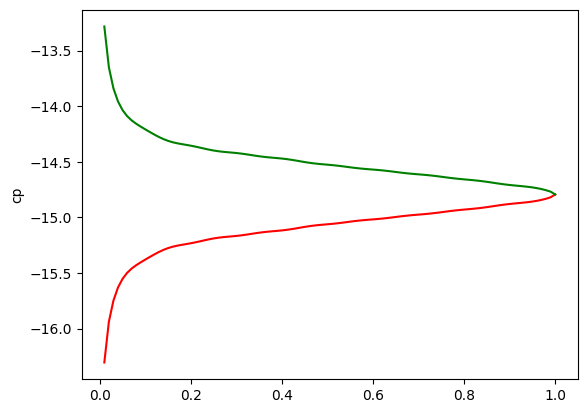

(0.8540213084619984,
 -0.21124525981243658,
 array([-16.30547272, -15.93863377, -15.74867625, -15.63118914,
        -15.55325518, -15.49952018, -15.46070715, -15.43044528,
        -15.40437884, -15.37990982, -15.35599436, -15.33279574,
        -15.31118657, -15.29219485, -15.27652553, -15.26427112,
        -15.25486715, -15.24727488, -15.24030815, -15.23298557,
        -15.2247918 , -15.21577048, -15.2064313 , -15.19751521,
        -15.1897049 , -15.18337928, -15.17849012, -15.1745931 ,
        -15.1710128 , -15.1670772 , -15.16233811, -15.15670307,
        -15.15043805, -15.14404653, -15.1380718 , -15.13289403,
        -15.12859206, -15.12491551, -15.1213733 , -15.11740487,
        -15.11257328, -15.10671398, -15.09998986, -15.09283647,
        -15.08581871, -15.07944923, -15.07403014, -15.06956954,
        -15.0657975 , -15.06227209, -15.05853625, -15.05427066,
        -15.04939178, -15.04406429, -15.03862793, -15.03346731,
        -15.02887183, -15.02493431, -15.02152171, -15.018325

In [56]:
airfoil1.solTAT(0.1,1)

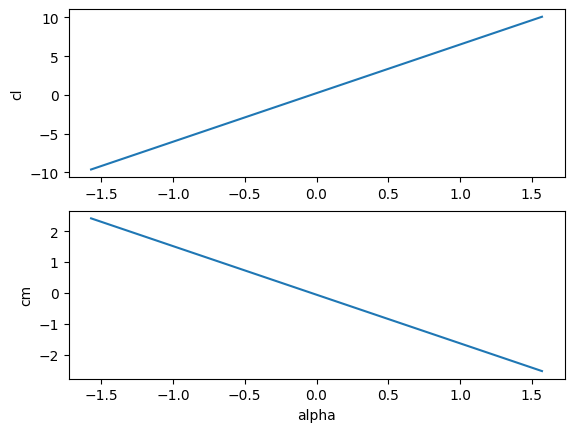

In [67]:
alpha = np.linspace(-np.pi/2,np.pi/2,25)
cl=np.zeros(alpha.shape)
cm=np.zeros(alpha.shape)
for i in range(0,25):
    cl[i],cm[i],cpu,cpl = airfoil1.solTAT(alpha[i],0)
plt.figure()
plt.subplot(2,1,1)
plt.plot(alpha,cl);
plt.ylabel('cl')
plt.subplot(2,1,2)
plt.plot(alpha,cm);
plt.ylabel('cm')
plt.xlabel('alpha');




    
